## Projeto Sprint 9

In [1]:
#importando bibliotecas
import pandas as pd
from scipy import stats
import math 
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

In [2]:
#importando os dados da prmeira parte e verificando estrutura
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv',sep=';') #Ao importar percebi que estavam todos juntos, por isso usamos o 'sep' para 'desagrupar'
hypotheses.info() #Os tipos de dados estão corretos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [3]:
#Verificando duplicados
hypotheses.duplicated().sum()

0

In [4]:
#Verificando valores ausente
hypotheses.isna().sum()

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Effort        0
dtype: int64

In [5]:
#importando os dados da segunda parte e verificando estrutura
orders = pd.read_csv('/datasets/orders_us.csv')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [6]:
#Alterando os tipos de dados
orders['date'] = orders['date'].map(
    lambda x:dt.datetime.strptime(x,"%Y-%m-%d"))

#Conferindo atualizações
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [7]:
#Vericando duplicados
orders.duplicated().sum()

0

In [8]:
#Vericando valores ausentes
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [9]:
#Verificando erros nos grupos
visits_repeat = (
    orders.groupby("visitorId")["group"].nunique()
)
visits_repeat = visits_repeat[visits_repeat > 1].index

print(f"Número de visitantes repetidos em ambos grupos:{len(visits_repeat)}") 

Número de visitantes repetidos em ambos grupos:58


In [10]:
#Optei por excluir os visitantes que estão em ambos os grupos, pois os dados são de grande estrutura, ou seja, não ficaia uma amostra pequena demais sem eles.
#E a presença deles influência do teste a/b que faremos
visits_clean = orders[~orders['visitorId'].isin(visits_repeat)].copy()
print(f"Linhas originais: {len(orders)}")
print(f"Linhas após limpeza: {len(visits_clean)}")
print(f"Visitantes únicos agora: {visits_clean['visitorId'].nunique()}")

Linhas originais: 1197
Linhas após limpeza: 1016
Visitantes únicos agora: 973


In [11]:
#importando os dados da segunda parte e verificando (conjunto de dados 'visits') 
visits = pd.read_csv('/datasets/visits_us.csv')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [12]:
#Alterando os tipos de dados
visits['date'] = visits['date'].map(
    lambda x:dt.datetime.strptime(x,"%Y-%m-%d"))

#Conferindo atualizações
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [13]:
#Verificando duplicados
visits.duplicated().sum()

0

In [14]:
#Verificando valores ausentes
visits.isna().sum()

date      0
group     0
visits    0
dtype: int64

### Parte 1. Priorizando Hipóteses

In [15]:
#Calculando o ICE,preferi não redefinir os index porque assim já podemos ver qual hipótese é qual(por exemplo, a hipótese 8 tem o maior ICE)
ICE = (hypotheses['Impact']*hypotheses['Confidence']) / hypotheses['Effort']
print(ICE.sort_values(ascending=False))

8    16.200000
0    13.333333
7    11.200000
6     8.000000
2     7.000000
1     2.000000
5     1.333333
3     1.125000
4     1.000000
dtype: float64


In [16]:
#Calculando o RICE,preferi não redefinir os index porque assim já podemos ver qual hipótese é qual(por exemplo, a hipótese 7 tem o maior RICE)
RICE = (hypotheses['Reach']*hypotheses['Impact']*hypotheses['Confidence']) / hypotheses['Effort']
print(RICE.sort_values(ascending=False))

7    112.0
2     56.0
0     40.0
6     40.0
8     16.2
3      9.0
1      4.0
5      4.0
4      3.0
dtype: float64


#### Comentário da aluna:
É possível perceber a variação do ICE para o RICE e vice versa, enquanto o ICE maior pertence a hipótese 8, o RICE maior pertence a hipótese 7.
Além disso, a ordem que os segue é quase toda difernte, com exclusão das hipóteses 6 e 4 que ficaram na mesma ordem.
Provavelmente as alterações se devem a variavél 'Reach'('Alcance'), já que é a única diferença entre o ICE e o RICE.
Ou seja, a hipótese 8 provavelmente é a que mais impacta, de mais confiança e menos esforço, porém não tem tanto alcance. 

### Parte 2. Análise de teste A/B

In [17]:
#Dados agregados por grupo
datesGroup = orders[['date','group']].drop_duplicates()
#Dados diários cumulativos agregados sobre os pedidos
ordersAggregated = datesGroup.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],orders['group'] == x['group'])].agg({'date':'max','group':'max','transactionId':pd.Series.nunique,'visitorId':pd.Series.nunique, 'revenue':'sum'}),axis=1).sort_values(by=['date','group'])
print(ordersAggregated.head())


          date group  transactionId  visitorId  revenue
55  2019-08-01     A             24         20   2356.8
66  2019-08-01     B             21         20   1620.0
175 2019-08-02     A             44         38   3860.3
173 2019-08-02     B             45         43   4243.8
291 2019-08-03     A             68         62   5675.5


In [18]:
#Dados diários cumulativos agregados sobre os visitantes
visitorsAggregated = datesGroup.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'],visits['group'] == x['group'])].agg({'date':'max','group':'max','visits':'sum'}),axis=1).sort_values(by=['date','group'])

In [19]:
#Juntando as duas tabelas
cumulativeData = ordersAggregated.merge(visitorsAggregated,left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns= ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
print(cumulativeData.head())

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   2356.8       719
1 2019-08-01     B      21      20   1620.0       713
2 2019-08-02     A      44      38   3860.3      1338
3 2019-08-02     B      45      43   4243.8      1294
4 2019-08-03     A      68      62   5675.5      1845


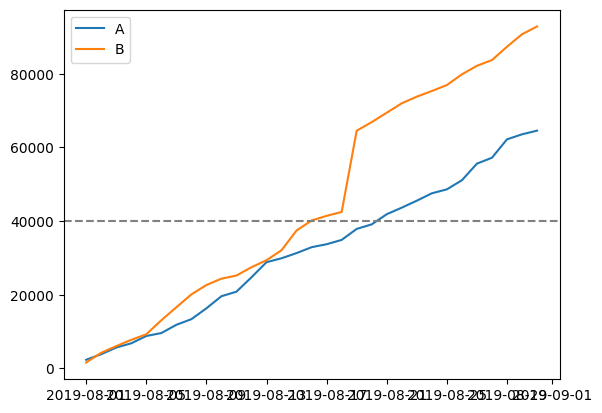

In [53]:
#1. Gráfico da receita acumulada por grupo
#Receita Grupo A
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue','orders']]

#Receita Grupo B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue','orders']]

# construindo o gráfico de receita do grupo A 
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# construindo o gráfico de receita do grupo B 
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.axhline(y=40000, color='gray', linestyle='--')

#### Comentário da aluna:
Pelo gráfico é possível verificar que o grupo B tem uma receita maior que o grupo A, embora ambos estejam em crescimento.

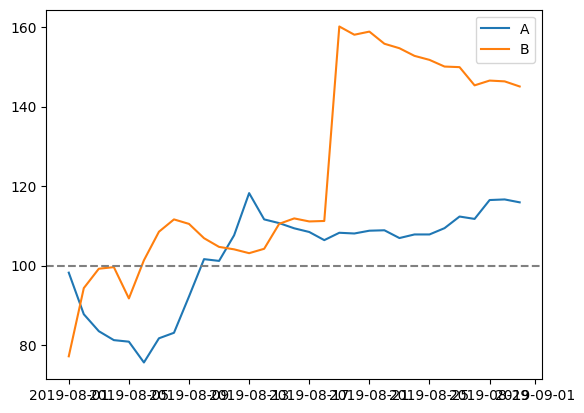

In [54]:
#2. Gráfico do tamanho médio acumulado do pedido por grupo
plt.plot(cumulativeRevenueA['date'],cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'],label='A')
plt.plot(cumulativeRevenueB['date'],cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'],label='B')
plt.legend()
plt.axhline(y=100, color='gray', linestyle='--')

#### Comentário da aluna: 
O volume médio por pedido sofreu bastante alterações,tanto no grupo A como no grupo B, tendo um pico no grupo B.
Talvez o pico ocorrido no grupo B, sejam pedidos mais caros, com valores maiores do que a média ou até pedidos maiores.

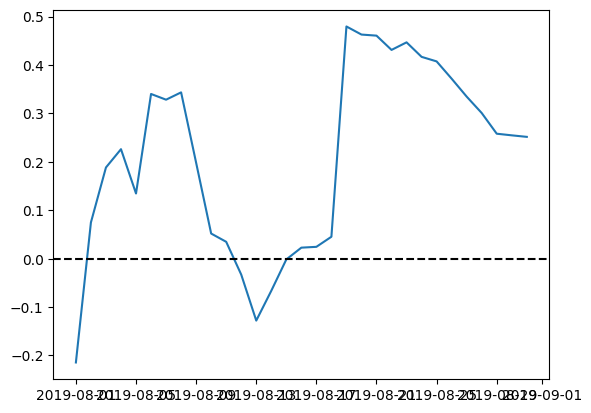

In [22]:
#3. Gráfico da diferença relativa no tamanho médio acumulado do pedido
#Juntando os dados
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

#Criando o gráfico
plt.plot(mergedCumulativeRevenue['date'],(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

#Eixo x
plt.axhline(y=0,color='black',linestyle='--')

#### Comentário da aluna:
O gráfico apresenta dois grandes picos, podendo ser um ou mais pedidos maiores que a média, ou um valor muito acima da média. 

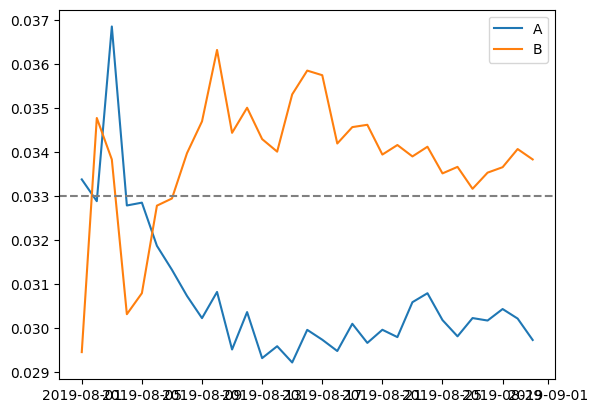

In [55]:
#4. Taxa de conversão de cada grupo
#Obtendo a conversão cumulativa
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

#Dados grupo A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
#Dados grupo B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

#Gráficos
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'],label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'],label='B')
plt.legend()
plt.axhline(y=0.033, color='gray', linestyle='--')

#### Comentário da aluna:
O grupo A teve um pico de coversão no início, mas logo decaiu e não voltou a ter grande crescimento. Já o grupo B, começou com uma taxa de conversão menor que o grupo A, mas ao longo do teste mostrou-se melhor que o grupo A, uma vez que continuou a crescer. 

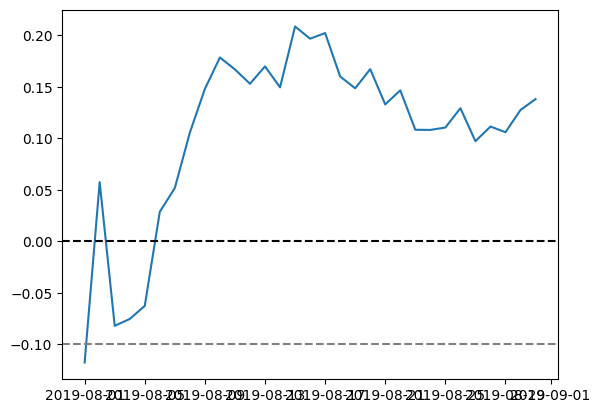

In [24]:
#5. Gráfico da diferença relativa na conversão cumulativa
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']],left_on='date',right_on='date',how='left',suffixes=['A','B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

#### Comentário da aluna:
No início o grupo B estava pior do que o grupo A, porém tivemos um pico onde isso se inverte. 
Após um tempo, o grupo supera e se mantém melhor que o grupo A, com algumas mudanças, mas ainda sim melhor.

In [25]:
#6.Percentis 95 e 99 para o número de pedidos por usuário
#Criando a variáveel de numero de pedidos por usuário
ordersByUsers =(
    orders.drop(['group','revenue','date'],axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['userId', 'orders']
print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

          userId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


(array([937.,  64.,  17.,   3.,   6.,   0.,   0.,   1.,   1.,   2.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

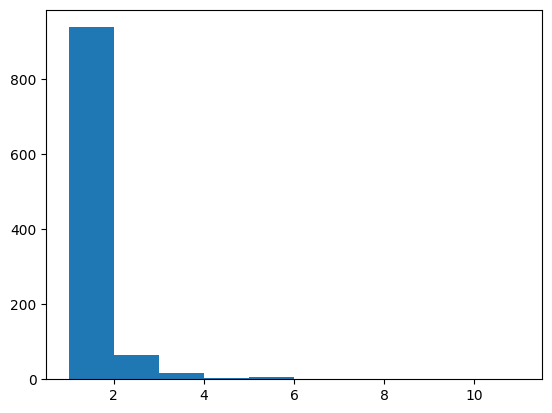

In [26]:
#Criando histograma para definir média padrão
plt.hist(ordersByUsers['orders'])

#### Comentário da aluna:
A maioria dos clientes realizou somente um pedido, mas há uma parcela significante que realizou de 2 a 4 pedidos.

In [27]:
#Calculando percentis
print(np.percentile(ordersByUsers['orders'],[95,99]))

[2. 4.]


#### Comentário da aluna:
Pelo menos 5% dos usuários fizeram 2 pedidos, e apenas 1% fez mais do que 4 pedidos. Ou seja, podemos definir como média de 1 a 5, passando disso seria considerado anomalia.

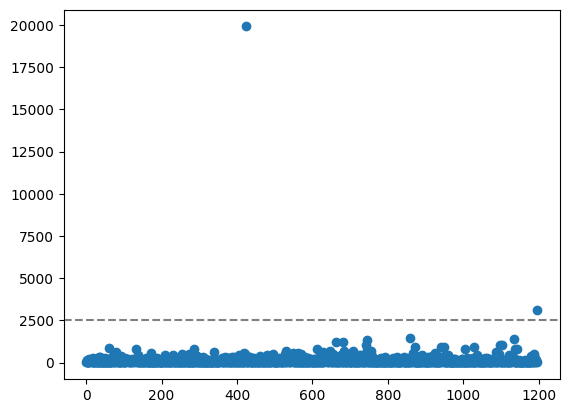

In [56]:
#7. Gráfico de dispersão dos preços dos pedidos
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values,orders['revenue'])
plt.axhline(y=2500, color='gray', linestyle='--')

#### Comentário da aluna:
A maioria dos pedidos tem um valor menor que 2500, com exceção de dois pedidos. O maior pedido é de quase 20000, talvez seja um cliente que fez um pedido grande e único.

In [29]:
#8. Calcule os percentis 95 e 99 dos preços dos pedidos
print(np.percentile(orders['revenue'],[95,99]))

[435.54  900.904]


#### Comentário da aluna:
Conforme o gráfico, podemos ver que a média do preço dos pedidos é menor que 2500 (excluindo os valores atípicos), ou seja, qualquer valor maior que isso seria considerado uma anomalia.
Cerca de 5% dos pedidos tem um valor de 435,54 e 1% de 900.

In [30]:
#9. significância estatística da diferença na conversão
#Filtrando os dados por grupo
ordersByUserA = orders[orders['group']=='A'].groupby('visitorId',as_index=False).agg({'transactionId': pd.Series.nunique})
ordersByUserA.columns=['visitorId','orders']

ordersByUserB = orders[orders['group']=='B'].groupby('visitorId',as_index=False).agg({'transactionId': pd.Series.nunique})
ordersByUserB.columns=['visitorId','orders']

In [31]:
#Concatenando amostras
sampleA = pd.concat([ordersByUserA['orders'],pd.Series(0,index=np.arange(visits[visits['group'] =='A']['visits'].sum() - len(ordersByUserA['orders'])),name='orders')],axis=0)
sampleB = pd.concat([ordersByUserB['orders'],pd.Series(0,index=np.arange(visits[visits['group'] =='B']['visits'].sum() - len(ordersByUserB['orders'])),name='orders')],axis=0)

In [32]:
#Calculando a taxa de conversão com três casas decimais
print("{0:.3}".format(stats.mannwhitneyu(sampleA,sampleB)[1]))
print("{0:.3}".format(sampleB.mean()/sampleA.mean()-1))

0.0168
0.138


#### Comentário da aluna:
A primeira linha do resultado é o valor-p, que pe menor do que 0.05, então podemos rejeitar a hipótese nula de que não há diferença estastística significativa na conversão entre os grupo. O segundo resultado nos informa de que que temos obtido sucesso no grupo B.

In [33]:
#10. Significância estatística da diferença no tamanho médio do pedido
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.692
0.252


#### Comentário da aluna:
O primeiro resultado é o valor-p, sendo ele maior que 0.05, então não há motivo para rejeitar a hipótese nula e concluir que o volume médio de pedidos seria diferente entre os grupos. Sendo o segundo valor positivo, concluimos que o grupo B está indo melhor que o grupo A.

In [34]:
#Filtrando os dados
usersWithManyOrders = pd.concat([ordersByUserA[ordersByUserA['orders'] > 2]['visitorId'],ordersByUserB[ordersByUserB['orders'] > 2]['visitorId']],axis=0)
usersWithExpensiveOrders = orders[orders['revenue'] > 2500]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders,usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()

In [35]:
#11.Significância estatística da diferença na conversão entre os grupos usando os dados filtrados
#Filtrando as amostras
sampleAFiltered = pd.concat([ordersByUserA[np.logical_not(ordersByUserA['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0,index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUserA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUserB[np.logical_not(ordersByUserB['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0,index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUserB['orders'])),name='orders')],axis=0)

In [36]:
#Calculando a estastística
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.014
0.166


#### Comentário da aluna:
Houve uma alteração em relação aos dados brutos, mas nada que fosse interverir no resultado final.

In [37]:
#12. Significância estatística da diferença no tamanho médio do pedido entre os grupos usando os dados filtrados
print("{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group'] =='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group'] == 'B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() /
    orders[np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() -1
))

0.635
-0.098


#### Comentário da aluna:
O valor-p sofreu uma leve diminuição, já a diferença mudou radicalmente, revelando que na verdade o grupo A está mais promissor que o B.

##### 13. 
Durante todo o teste o Grupo B se mostrou melhor que o Grupo A, porém com os dados filtrados, a significância estatística da diferença no tamanho médio do pedido entre os grupos, mostrou que o grupo A tem um tamanho médio de pedidos maior que B. Provavelmente os valores atípicos estão no grupo B que estava elevando a sua média. Eu confirmaria essa informação, pararia os testes, e com base na informação escolheria um dos grupos. 

In [43]:
print(orders[(orders['group'] == 'B') & (orders['revenue'] > 2500)])

      transactionId   visitorId       date  revenue group
425       590470918  1920142716 2019-08-19  19920.4     B
1196     3936777065  2108080724 2019-08-15   3120.1     B


In [44]:
print(orders[(orders['group'] == 'A') & (orders['revenue'] > 2500)])

Empty DataFrame
Columns: [transactionId, visitorId, date, revenue, group]
Index: []


Levantando em consideração que somente o volume médio de pedidos sofreu uma grande alteração quando calculado com os dados filtrados, e contendo o Grupo B os dois valores mais altos do que a média. Acredito que a melhor opção seja o Grupo B, que se mostrou m sucesso durante todo os testes, com exceção do volume médio filtrada, mas que só houve alteração por causa dos valores atípicos. Nos restantes testes, não mostrou alterações significativas que indicasse que o Grupo A era melhor que o Grupo B.